# Chapter 3 - Statistical Experiments and Significance Testing

In [2]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [4]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

## A/B Testing

**Treatment**: Something (drug, price, web headline) to which a subject is exposed.

**Treatment group**: A group of subjects exposed to a specific treatment.

**Control group**: A group of subjects exposed to no (or standard) treatment.

**Randomization**: The process of randomly assigning subjects to treatments.

**Subjects**: The items (web visitors, patients, etc.) that are exposed to treatments.

**Test statistic**: The metric used to measure the effect of the treatment.

• Subjects are assigned to two (or more) groups that are treated exactly alike, except that the treatment under study differs from one group to another.

• Ideally, subjects are assigned randomly to the groups.


## Hypothesis Tests

**Null hypothesis**: The hypothesis that chance is to blame.

**Alternative hypothesis**: Counterpoint to the null (what you hope to prove).

**One-way test**: Hypothesis test that counts chance results only in one direction.

**Two-way test**: Hypothesis test that counts chance results in two directions.

• A null hypothesis is a logical construct embodying the notion that nothing special has happened, and any effect you observe is due to random chance.

• The hypothesis test assumes that the null hypothesis is true, creates a “null model” (a probability model), and tests whether the effect you observe is a reasonable outcome of that model.

## Resampling

**Permutation test**: The procedure of combining two or more samples together and randomly (or exhaustively) reallocating the observations to resamples. Synonyms Randomization test, random permutation test, exact test

**Resampling**: Drawing additional samples (“resamples”) from an observed data set.

**With or without replacement**: In sampling, whether or not an item is returned to the sample before the next draw.


In [5]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

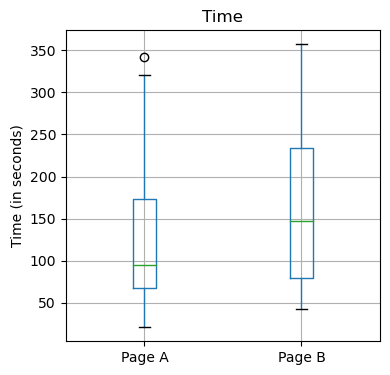

In [6]:
ax = session_times.boxplot(by='Page', column='Time',
                            figsize=(4, 4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [7]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


In [8]:
# Permutation test example with stickiness
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

-8.219047619047615


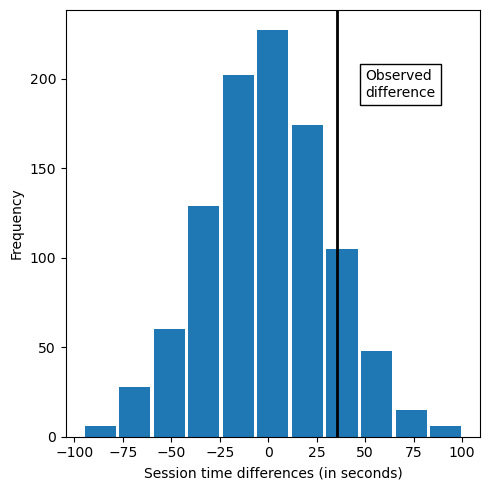

In [9]:
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
# convert perm_diffs to numpy array to avoid problems with some Python installations
perm_diffs = np.array(perm_diffs)
print(np.mean(perm_diffs > mean_b - mean_a))

0.121


• In a permutation test, multiple samples are combined and then shuffled.

• The shuffled values are then divided into resamples, and the statistic of interest is calculated.

## Statistical Significance and p-Values

**p-value**: Given a chance model that embodies the null hypothesis, the p-value is the probability of obtaining results as unusual or extreme as the observed results.

**Alpha**: The probability threshold of “unusualness” that chance results must surpass for actual outcomes to be deemed statistically significant.

**Type 1 error**: Mistakenly concluding an effect is real (when it is due to chance).

**Type 2 error**: Mistakenly concluding an effect is due to chance (when it is real).

Observed difference: 0.0368%


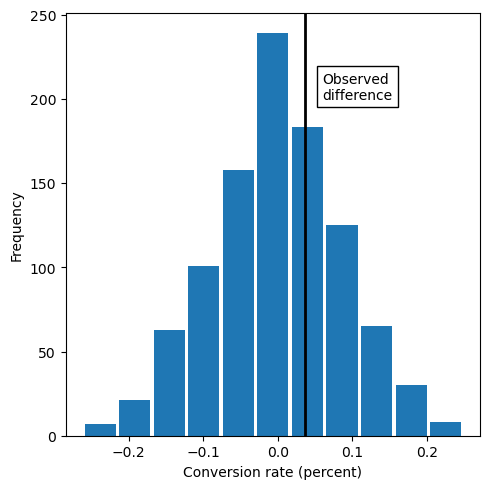

In [11]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Observed difference: 0.0368%


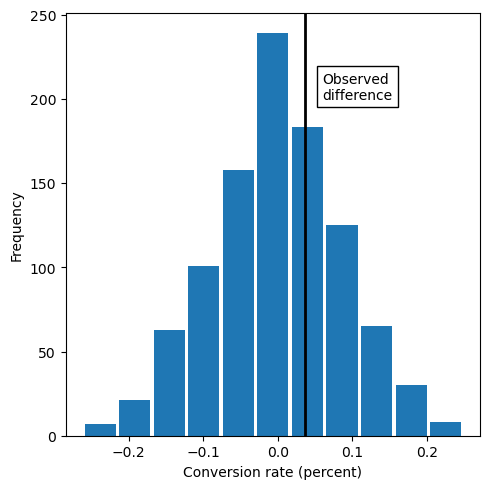

In [12]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [13]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


In [14]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


• Significance tests are used to determine whether an observed effect is within the range of chance variation for a null hypothesis model.

• The p-value is the probability that results as extreme as the observed results might occur, given a null hypothesis model.

• The alpha value is the threshold of “unusualness” in a null hypothesis chance model.

• Significance testing has been much more relevant for formal reporting of research than for data science (but has been fading recently, even for the former).


## t-Tests

**Test statistic**: A metric for the difference or effect of interest.

**t-statistic**: A standardized version of common test statistics such as means.

**t-distribution**: A reference distribution (in this case derived from the null hypothesis), to which the observed t-statistic can be compared.

In [15]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time,
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


• Before the advent of computers, resampling tests were not practical, and statisticians used standard reference distributions.

• A test statistic could then be standardized and compared to the reference distribution.

• One such widely used standardized statistic is the t-statistic.

In [16]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
print(f'p-value: {pvalue:.4f}')

p-value: 0.1408


## Multiple Testing

**Type 1 error**: Mistakenly concluding that an effect is statistically significant.

**False discovery rate**: Across multiple tests, the rate of making a Type 1 error.

**Alpha inflation**: The multiple testing phenomenon, in which alpha, the probability of making a Type 1 error, increases as you conduct more tests.

**Adjustment of p-values**: Accounting for doing multiple tests on the same data.

**Overfitting**: Fitting the noise.


• Multiplicity in a research study or data mining project (multiple comparisons, many variables, many models, etc.) increases the risk of concluding that something is significant just by chance.

• For situations involving multiple statistical comparisons (i.e., multiple tests of significance), there are statistical adjustment procedures.

• In a data mining situation, use of a holdout sample with labeled outcome variables can help avoid misleading results

## Degrees of Freedom

**n or sample size**: The number of observations (also called rows or records) in the data.

**d.f.**: Degrees of freedom.

• The number of degrees of freedom (d.f.) forms part of the calculation to standardize test statistics so they can be compared to reference distributions (t-distribution, F-distribution, etc.).

• The concept of degrees of freedom lies behind the factoring of categorical variables into n – 1 indicator or dummy variables when doing a regression (to avoid multicollinearity).

## ANOVA

**Pairwise comparison**: A hypothesis test (e.g., of means) between two groups among multiple groups.

**Omnibus test**: A single hypothesis test of the overall variance among multiple group means.

**Decomposition of variance**: Separation of components contributing to an individual value (e.g., from the overall average, from a treatment mean, and from a residual error).

**F-statistic**: A standardized statistic that measures the extent to which differences among group means exceed what might be expected in a chance model.

**SS**: “Sum of squares,” referring to deviations from some average value.

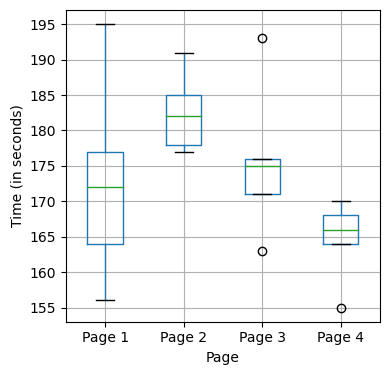

In [17]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [18]:
print(pd.read_csv(FOUR_SESSIONS_CSV).head())

     Page  Time
0  Page 1   164
1  Page 2   178
2  Page 3   175
3  Page 4   155
4  Page 1   172


In [19]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)
# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
14.68000000000003


Pr(Prob) 0.08733333333333333


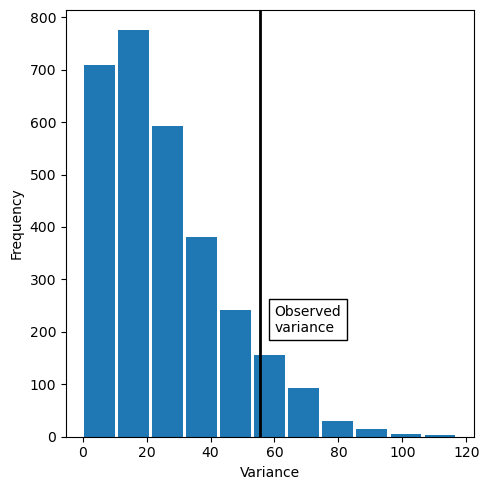

In [20]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [21]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [22]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

F-Statistic: 1.3699
p-value: 0.0388


• ANOVA is a statistical procedure for analyzing the results of an experiment with multiple groups.

• It is the extension of similar procedures for the A/B test, used to assess whether the overall variation among groups is within the range of chance variation.

• A useful outcome of ANOVA is the identification of variance components associated with group treatments, interaction effects, and errors.

## Chi-Square Test

**Chi-square statistic**: A measure of the extent to which some observed data departs from expectation.

**Expectation or expected**: How we would expect the data to turn out under some assumption, typically the null hypothesis.

In [23]:
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


In [24]:
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})


,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [25]:
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [expected_clicks, expected_noclicks]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    random.shuffle(box)
    sample_clicks = [sum(box[0:1000]),
                    sum(box[1000:2000]),
                    sum(box[2000:3000])]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4660


In [26]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


In [27]:
expected = [expected_clicks, expected_noclicks]
def sample_with_replacement(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [sample_with_replacement(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4845


• A common procedure in statistics is to test whether observed data counts are consistent with an assumption of independence (e.g., propensity to buy a particular item is independent of gender).

• The chi-square distribution is the reference distribution (which embodies the assumption of independence) to which the observed calculated chi-square statistic must be compared.

## Multi-Arm Bandit Algorithm

**Multi-arm bandit**: An imaginary slot machine with multiple arms for the customer to choose from, each with different payoffs, here taken to be an analogy for a multitreatment experiment.

**Arm**: A treatment in an experiment (e.g., “headline A in a web test”).

**Win**: The experimental analog of a win at the slot machine (e.g., “customer clicks on the link”).

• Traditional A/B tests envision a random sampling process, which can lead to excessive exposure to the inferior treatment.

• Multi-arm bandits, in contrast, alter the sampling process to incorporate information learned during the experiment and reduce the frequency of the inferior treatment.

• They also facilitate efficient treatment of more than two treatments.

• There are different algorithms for shifting sampling probability away from the inferior treatment(s) and to the (presumed) superior one.

## Power and Sample Size

**Effect size**: The minimum size of the effect that you hope to be able to detect in a statistical test, such as “a 20% improvement in click rates.”

**Power**: The probability of detecting a given effect size with a given sample size.

**Significance level**: The statistical significance level at which the test will be conducted.

In [ ]:
# effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
# analysis = sm.stats.TTestIndPower()
# result = analysis.solve_power(effect_size=effect_size, 
#                               alpha=0.05, power=0.8, alternative='larger')
# print('Sample Size: %.3f' % result)

In [28]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408


• Finding out how big a sample size you need requires thinking ahead to the statistical test you plan to conduct.

• You must specify the minimum size of the effect that you want to detect.

• You must also specify the required probability of detecting that effect size (power).

• Finally, you must specify the significance level (alpha) at which the test will be conducted.